## 1. Dataset & Provenance

This project uses a consumer loan performance dataset originally published by LendingClub Corporation, a regulated U.S. peer-to-peer lending platform. LendingClub is legally required to disclose loan statistics, including performance outcomes (fully paid vs. default/charged-off), through the U.S. Securities and Exchange Commission’s (SEC) EDGAR regulatory filings database.

The dataset contains real applicant features such as annual income, credit history, employment length, debt-to-income ratio, loan purpose, interest rates, and repayment status. These features enable a supervised learning task to predict whether a loan will default.

#### Primary (Official) Data Source:
U.S. Securities and Exchange Commission (SEC) EDGAR Financial Filings for LendingClub
(Loan statistics are obtained from required regulatory financial disclosures.)

#### Practical Dataset Location Used in This Project:
A mirrored public version of the same loan performance data hosted on Kaggle for research convenience:
https://www.kaggle.com/datasets/nikhil1e9/loan-default

Kaggle hosts a cleaned, consolidated version of the original SEC filings, making it easier to load and process in machine learning notebooks, while preserving the same structure and real loan performance fields from the official SEC source.

## 2. Deep Learning Problem Definition

### Problem Statement

Consumer lenders face the question: **given information about a loan application, can we predict whether the loan will eventually default?**  

Using historical LendingClub loan data, I frame this as a **binary classification** problem:

- **Target variable:** whether a loan ends up **defaulting / being charged off** vs **fully paid**.
- **Input features:** borrower financial and credit information, such as annual income, debt-to-income ratio, FICO score range, number of past delinquencies, employment length, loan amount, loan purpose, interest rate, and similar variables.

Accurately identifying high‐risk loans is important for **credit risk management** and **capital allocation**, but also comes with fairness concerns: different groups of borrowers (e.g., lower vs higher income, different employment histories) may experience systematically different error rates.



### Focus of This Project

This project specifically focuses on two aspects:

1. **Class Imbalance in Default Prediction**

   In most real consumer lending portfolios, the majority of loans are **non-defaulting**, while true defaults are relatively rare. I expect a similar pattern in this dataset: many loans will be fully paid, and only a minority will be charged off.

   A naive model optimized purely for accuracy could learn to almost always predict “no default” and still achieve a high accuracy while being useless for risk management.

   I will therefore:
   - Quantify the **class imbalance** between default and non-default loans.
   - Train deep learning models both **with and without** imbalance-handling techniques (e.g., class weighting, resampling, and/or alternative loss functions such as focal loss).
   - Compare their performance using metrics that are more appropriate for imbalanced data (precision, recall, F1, ROC–AUC, PR–AUC), not just raw accuracy.

2. **Fairness and Group-wise Performance**

   Even if a model performs well on average, it may perform differently for different **subgroups of borrowers** (for example, by income bands, employment length categories, or loan purposes). This can raise fairness concerns if some groups experience systematically higher false-positive or false-negative rates.

   In this project I will:
   - Define several **non-sensitive subgroups** (e.g., low/medium/high income, short vs long employment history, secured vs unsecured purposes).
   - Evaluate the trained deep learning model **separately for each subgroup**, comparing metrics such as recall and false negative rate.
   - Discuss where the model appears to be more or less reliable across groups, and highlight limitations and ethical considerations.  
   The goal is not to build a production-ready credit scoring system but to **illustrate how class imbalance and fairness issues show up in real loan default data.**



### Deep Learning Approach

I will use **Keras (TensorFlow)** to build and train a **feed-forward deep neural network (multilayer perceptron, MLP)** for this tabular prediction task. The core model will take as input:

- Normalized numerical features (income, DTI, FICO band, interest rate, etc.).
- One-hot or embedded representations of categorical features (loan purpose, employment length bucket, home ownership category, etc.).

Planned modeling steps:

1. **Baseline Model:**  
   - A simple MLP trained with standard binary cross-entropy on the imbalanced data.  
   - This establishes how a deep model behaves without any imbalance correction.

2. **Imbalance-Aware Deep Models:**  
   - MLP trained with **class weights** or **focal loss** to give more importance to the minority (default) class.  
   - Optionally, an additional experiment using **oversampling** (e.g., random oversampling of default cases) feeding into the MLP.

3. **Fairness Evaluation:**  
   - For the best-performing MLP, compute and compare metrics across predefined borrower subgroups (income bands, employment length categories, loan purpose groups).
   - Discuss trade-offs between overall performance and group-wise performance, and the limitations of this analysis (e.g., absence of legally protected attributes in the dataset, observational nature of the data).

### 3. Load Dataset/ EDA

We begin by loading the dataset and previewing its structure.

In [26]:
import pandas as pd
import numpy as np

df = pd.read_csv('Loan_default.csv')
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [27]:
df.isna().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

### 3.1 Feature Selection

To predict loan default, we keep borrower financial and credit risk features that directly influence loan repayment behavior:

| Feature | Type | Why It Matters |
|---------|------|----------------|
| `Age` | numeric | Proxy for credit maturity + earning power |
| `Income` | numeric | Ability to repay |
| `LoanAmount` | numeric | Larger loans → potential higher financial stress |
| `InterestRate` | numeric | Higher rates reflect higher risk |
| `LoanTerm` | numeric/categorical | Payment length affects risk |
| `CreditScore` | numeric | Direct proxy for creditworthiness |
| `MonthsEmployed` | numeric | Employment stability decreases default risk |
| `NumCreditLines` | numeric | Credit history depth |
| `DTIRatio` | numeric | Debt burden indicator |
| `HasMortgage`, `HasDependents`, `HasCoSigner` | binary/categorical | Structural financial responsibility |
| `LoanPurpose` | categorical | Borrower intent impacts repayment behavior |
| `EmploymentType`, `Education`, `MaritalStatus` | categorical | Socioeconomic stability proxies |
| `Default` | target | Binary default outcome (1 = default, 0 = paid) |

We will analyze financial patterns and fairness between subgroups (e.g., income levels, employment duration) to study **class imbalance and bias effects.**

In [28]:
df = df[['Age','Income','LoanAmount','CreditScore','MonthsEmployed',
         'NumCreditLines','InterestRate','LoanTerm','DTIRatio',
         'Education','EmploymentType','MaritalStatus','HasMortgage',
         'HasDependents','LoanPurpose','HasCoSigner','Default']].copy()

df.head

<bound method NDFrame.head of         Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0        56   85994       50587          520              80               4   
1        69   50432      124440          458              15               1   
2        46   84208      129188          451              26               3   
3        32   31713       44799          743               0               3   
4        60   20437        9139          633               8               4   
...     ...     ...         ...          ...             ...             ...   
255342   19   37979      210682          541             109               4   
255343   32   51953      189899          511              14               2   
255344   56   84820      208294          597              70               3   
255345   42   85109       60575          809              40               1   
255346   62   22418       18481          636             113               2   

        I

### 3.2 Class Imbalance

Loan default datasets are naturally imbalanced: most borrowers repay, while default cases are rare but costly.  
Imbalanced data can cause models to predict **“no default”** for most cases and still appear accurate.  
Therefore, we visualize and quantify the imbalance before modeling.

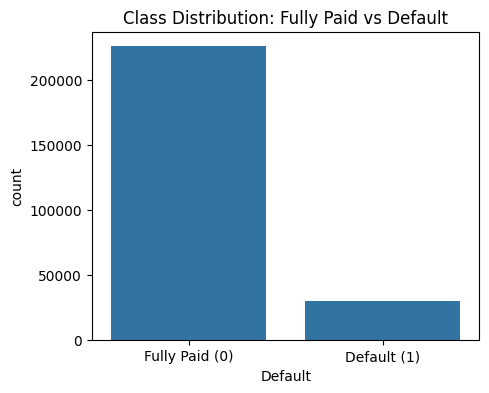

Default
0    88.4
1    11.6
Name: proportion, dtype: float64


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x='Default', data=df)
plt.title('Class Distribution: Fully Paid vs Default')
plt.xticks([0,1], ['Fully Paid (0)', 'Default (1)'])
plt.show()

print(df['Default'].value_counts(normalize=True).round(3) * 100)

**Observations**

The dataset is highly imbalanced: approximately **88% of loans are fully paid** while only **about 12% end in default**. This reflects realistic lending portfolios, where most borrowers repay their loans and default events are comparatively rare.

This imbalance has important implications for modeling:

- Traditional accuracy alone would be misleading a naïve model predicting “no default” for every borrower would still achieve ~88% accuracy while being useless for risk management.
- The minority class (defaults) must be emphasized during training using approaches such as **class weights**, **oversampling**, or specialized loss functions (e.g., focal loss).
- Evaluation metrics must go beyond accuracy and include **precision, recall, F1-score, ROC-AUC**, and **PR-AUC**, which are more informative for imbalanced classification.

Therefore, handling class imbalance should be considered a core part of the modeling strategy in Step 4.

### 3.3 Relationship Between Features and Default

We compare risk patterns by visualizing how financial variables differ between defaults and non-defaults.  
Higher interest rates, lower income, lower credit score, or higher DTI may correlate with higher default risk.

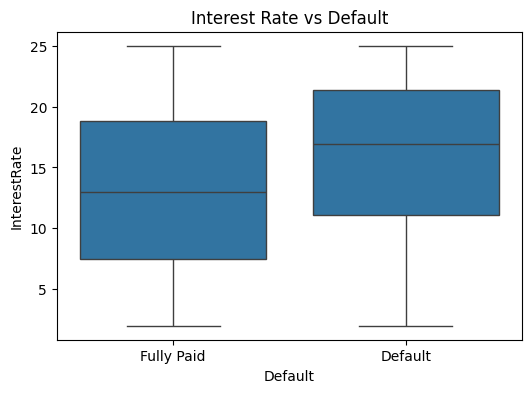

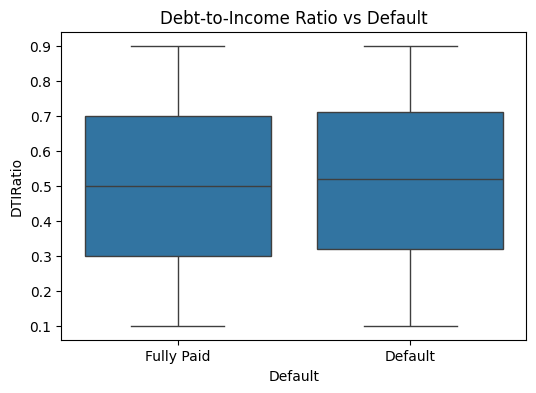

In [80]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Default', y='InterestRate', data=df)
plt.title('Interest Rate vs Default')
plt.xticks([0,1], ['Fully Paid','Default'])
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='Default', y='DTIRatio', data=df)
plt.title('Debt-to-Income Ratio vs Default')
plt.xticks([0,1], ['Fully Paid','Default'])
plt.show()

**Observations**

- **Borrowers who default tend to have higher interest rates.** This follows lending logic: risk based pricing charges higher interest to borrowers perceived as riskier.
- **Borrowers with higher DTI ratios also show a higher default tendency**, indicating that borrowers already burdened with significant debt are more likely to fail to repay.
- The trends are noticeable but **not extreme**, suggesting that default risk is influenced by multiple features rather than a single decisive variable.

These results validate the need for multivariate modeling individual features influence risk, but the combination of credit, income, loan burden, and rates collectively determine default outcomes.

### 3.4 Fairness: Group Level Behavior

Models may treat subgroups differently. We explore default rates across income groups, employment stability, and loan purposes to detect disparities before training models.

/var/folders/jj/l72sd2c50fsc18zws0_3f4ph0000gn/T/ipykernel_75697/2438998099.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('IncomeGroup')['Default'].mean().mul(100).plot(kind='bar', figsize=(6,4))


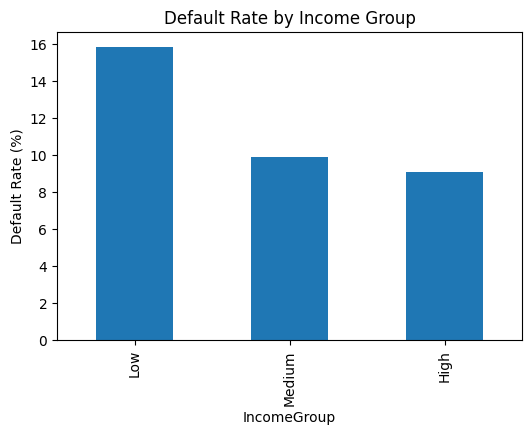

In [32]:
df['IncomeGroup'] = pd.qcut(df['Income'], 3, labels=['Low','Medium','High'])
df.groupby('IncomeGroup')['Default'].mean().mul(100).plot(kind='bar', figsize=(6,4))
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Income Group')
plt.show()

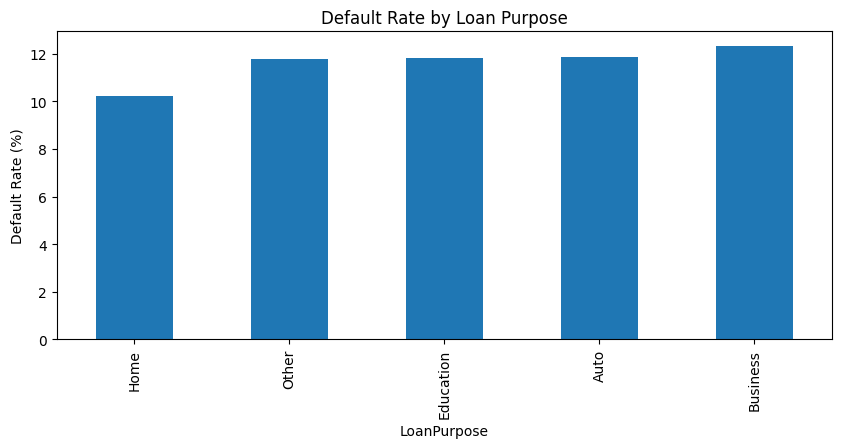

In [33]:
purpose_default = df.groupby('LoanPurpose')['Default'].mean().mul(100).sort_values()
purpose_default.plot(kind='bar', figsize=(10,4))
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Loan Purpose')
plt.show()

**Observations**

- **Low-income borrowers have the highest default rate (~16%)**, compared to medium (~ 10%) and high income (~ 9%).  
  This shows a clear socioeconomic disparity: borrowers with lower ability to repay are more vulnerable to default.
- **Default rates also vary by loan purpose**, with business, education, and “other” loans showing the highest default rates. Borrowers taking loans for discretionary or entrepreneurial reasons may face higher financial uncertainty than those borrowing for essential needs (e.g., home or auto).
- These variations imply that **a model might unintentionally penalize certain borrower groups**, especially lower-income applicants or those with specific loan purposes.

Thus, fairness should be evaluated when deploying a predictive model: performance differences between borrower groups may exacerbate financial inequality if unchecked.

### 3.5 Conclusion from EDA

The EDA confirms two key characteristics of real consumer lending data:

1. **Loan defaults are rare**, illustrating a strong class imbalance that must be handled during model training.
2. **Default risk differs across borrower subgroups**, especially by income level and loan purpose, suggesting potential fairness concerns if a model is not evaluated across subgroups.



## 4 Deep Learning Models, Imbalance Handling, and Fairness

The EDA showed that (1) defaults are rare (~12% of loans) and (2) default risk varies across
income levels and loan purposes. In this step I build Keras deep learning models to predict loan
default, first on the raw imbalanced data and then with imbalance-aware training using class
weights. I also keep the fairness perspective in mind for subsequent subgroup evaluation.

### Reloading the Dataset and Creating a Modeling Table

Before building a deep learning model, I reload the dataset from the original CSV to ensure that 
no accidental transformations from earlier EDA steps carry over. This creates a fully clean 
modeling table.

Binary categorical variables such as *HasMortgage*, *HasDependents*, and *HasCoSigner* represent 
Yes/No indicators. These are mapped to numeric values (1/0) so they can be used directly by the 
model without requiring one-hot encoding.

The modeling dataset only includes features directly relevant to prediction to avoid adding 
EDA-derived columns such as income groups.

In [59]:
import pandas as pd
import numpy as np

# Fresh load from CSV
df_raw = pd.read_csv('Loan_default.csv')

# Map binary Yes/No fields to 1/0
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
for col in binary_cols:
    df_raw[col] = df_raw[col].map({'Yes': 1, 'No': 0})

numeric_features = [
    'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
    'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
    'HasMortgage', 'HasDependents', 'HasCoSigner'
]

categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
target_col = 'Default'

# Modeling dataframe with only needed columns
df_model = df_raw[numeric_features + categorical_features + [target_col]].copy()

# Drop any unexpected missing values (rare, but ensures no NaNs enter the model)
df_model = df_model.dropna()

df_model.head(), df_model.isna().sum()

(   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
 0   56   85994       50587          520              80               4   
 1   69   50432      124440          458              15               1   
 2   46   84208      129188          451              26               3   
 3   32   31713       44799          743               0               3   
 4   60   20437        9139          633               8               4   
 
    InterestRate  LoanTerm  DTIRatio  HasMortgage  HasDependents  HasCoSigner  \
 0         15.23        36      0.44            1              1            1   
 1          4.81        60      0.68            0              0            1   
 2         21.17        24      0.31            1              1            0   
 3          7.07        24      0.23            0              0            0   
 4          6.51        48      0.73            0              1            0   
 
      Education EmploymentType MaritalStatus LoanPurpo

### 4.1 Splitting the Data

The dataset is split into training, validation, and test subsets.

- **Training set**: used to fit the model
- **Validation set**: used to choose model hyperparameters and detect overfitting
- **Test set**: held out until the very end for unbiased evaluation

Stratified sampling ensures that the proportion of defaults vs fully paid loans remains 
consistent across all splits.

In [60]:
from sklearn.model_selection import train_test_split

X = df_model[numeric_features + categorical_features]
y = df_model[target_col].values

X_train_df, X_temp_df, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val_df, X_test_df, y_val, y_test = train_test_split(
    X_temp_df, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

X_train_df.shape, X_val_df.shape, X_test_df.shape

((178742, 16), (38302, 16), (38303, 16))

### 4.2 Preprocessing for Deep Learning

Deep neural networks expect numeric, scaled inputs. Therefore:

- **Numerical features** are standardized using `StandardScaler`.
- **Categorical features** are *label-encoded into integer IDs* and later represented using 
  **embedding layers** inside the model. Embeddings allow the neural network to learn dense, 
  meaningful representations of categories instead of treating them as unrelated symbols.

This design leverages deep learning’s strengths, unlike a shallow model with one-hot encoding.

In [62]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

X_train = X_train_df.copy()
X_val   = X_val_df.copy()
X_test  = X_test_df.copy()

# Label encode each categorical feature
cat_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col]   = le.transform(X_val[col])
    X_test[col]  = le.transform(X_test[col])
    cat_encoders[col] = le

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_val_num   = scaler.transform(X_val[numeric_features])
X_test_num  = scaler.transform(X_test[numeric_features])

# Categorical integer arrays
X_train_cat = {col: X_train[col].astype('int32').values for col in categorical_features}
X_val_cat   = {col: X_val[col].astype('int32').values   for col in categorical_features}
X_test_cat  = {col: X_test[col].astype('int32').values  for col in categorical_features}

### 4.3 Model Architecture Overview

The model combines:
- A **numeric feature branch** (scaled continuous variables),
- Separate **embedding layers** for each categorical feature.

Each embedding layer learns a low dimensional dense representation of a category, enabling the 
network to capture similarities across education types, employment type, marital status, and 
loan purposes.

The embeddings and numeric inputs are concatenated, passed through fully-connected layers, and 
the model outputs a probability of default between 0 and 1.

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_model(embedding_dims=4, hidden_units=[64, 32], dropout_rate=0.3, lr=1e-3):
    num_input = layers.Input(shape=(len(numeric_features),), name="numeric_input")

    cat_inputs = []
    cat_embeds = []
    for col in categorical_features:
        n_cat = len(cat_encoders[col].classes_)
        inp = layers.Input(shape=(1,), name=f"{col}_input")
        emb = layers.Embedding(input_dim=n_cat, output_dim=min(embedding_dims, n_cat//2))(inp)
        emb = layers.Flatten()(emb)
        cat_inputs.append(inp)
        cat_embeds.append(emb)

    x = layers.Concatenate()( [num_input] + cat_embeds )

    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[num_input] + cat_inputs, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [65]:
def make_inputs(X_num, X_cat):
    inputs = {"numeric_input": X_num}
    for col in categorical_features:
        inputs[f"{col}_input"] = X_cat[col]
    return inputs

train_inputs = make_inputs(X_train_num, X_train_cat)
val_inputs   = make_inputs(X_val_num,   X_val_cat)
test_inputs  = make_inputs(X_test_num,  X_test_cat)

### 4.4 Baseline Model Training

This first model is trained on the imbalanced dataset using standard binary cross-entropy loss.
It serves as a baseline to compare against imbalance-aware models later.

In [66]:
baseline_model = build_model()
baseline_history = baseline_model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=10,
    batch_size=512,
    verbose=1
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8637 - auc: 0.5900 - loss: 0.3976 - val_accuracy: 0.8839 - val_auc: 0.7439 - val_loss: 0.3197
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.8843 - auc: 0.7162 - loss: 0.3301 - val_accuracy: 0.8841 - val_auc: 0.7503 - val_loss: 0.3154
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.8835 - auc: 0.7288 - loss: 0.3258 - val_accuracy: 0.8845 - val_auc: 0.7528 - val_loss: 0.3144
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.8841 - auc: 0.7300 - loss: 0.3242 - val_accuracy: 0.8861 - val_auc: 0.7549 - val_loss: 0.3130
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.8847 - auc: 0.7352 - loss: 0.3209 - val_accuracy: 0.8856 - val_auc: 0.7553 - val_loss: 0.3126
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.8829 - auc: 0.7373 - loss: 0.3235 - val_accuracy: 0.8857 - val_auc: 0.7566 - val_loss: 0.3121
Epoch 7/10
350/350 ━━━━━━━━━━━

### 4.5 Handling Class Imbalance with Class Weights

Since only ~12% of loans default, the baseline model may ignore minority-class loans. To encourage
the network to pay more attention to defaults, class weights increase the loss contribution of 
the minority class. This typically improves recall and AUC for default prediction.

In [67]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_dict = {
    int(c): w for c, w in zip(
        np.unique(y_train),
        compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    )
}

weighted_model = build_model()
weighted_history = weighted_model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=10,
    batch_size=512,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5974 - auc: 0.6650 - loss: 0.6497 - val_accuracy: 0.6733 - val_auc: 0.7476 - val_loss: 0.5982
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6665 - auc: 0.7320 - loss: 0.6060 - val_accuracy: 0.6790 - val_auc: 0.7523 - val_loss: 0.5913
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.6702 - auc: 0.7407 - loss: 0.5993 - val_accuracy: 0.6811 - val_auc: 0.7547 - val_loss: 0.5890
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.6767 - auc: 0.7444 - loss: 0.5981 - val_accuracy: 0.6855 - val_auc: 0.7549 - val_loss: 0.5794
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.6751 - auc: 0.7456 - loss: 0.6007 - val_accuracy: 0.6891 - val_auc: 0.7560 - val_loss: 0.5878
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6870 - auc: 0.7456 - loss: 0.5928 - val_accuracy: 0.6895 - val_auc: 0.7564 - val_loss: 0.5861
Epoch 7/10
350/350 ━━━━━━━━━━━

### 4.6 Model Evaluation

Both models are evaluated on the held-out test set to compare:
- Accuracy
- Recall and F1-score for the **default class**
- ROC-AUC

A model that better identifies defaulting loans (higher recall for class 1) is more appropriate 
for lending risk management even if its overall accuracy is slightly lower.

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model(model, name):
    print(f"\n=== {name} ===")
    proba = model.predict(test_inputs).ravel()
    preds = (proba >= 0.5).astype(int)

    print("ROC-AUC:", roc_auc_score(y_test, proba).round(4))
    print(classification_report(y_test, preds, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, preds))
    return preds, proba

print("\n")
base_pred, base_proba = evaluate_model(baseline_model, "Baseline model")
w_pred, w_proba       = evaluate_model(weighted_model, "Class-weighted model")




=== Baseline model ===
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
ROC-AUC: 0.7644
              precision    recall  f1-score   support

           0     0.8884    0.9959    0.9391     33855
           1     0.6040    0.0477    0.0884      4448

    accuracy                         0.8858     38303
   macro avg     0.7462    0.5218    0.5137     38303
weighted avg     0.8554    0.8858    0.8403     38303

Confusion matrix:
 [[33716   139]
 [ 4236   212]]

=== Class-weighted model ===
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
ROC-AUC: 0.7642
              precision    recall  f1-score   support

           0     0.9434    0.7102    0.8103     33855
           1     0.2345    0.6758    0.3482      4448

    accuracy                         0.7062     38303
   macro avg     0.5890    0.6930    0.5793     38303
weighted avg     0.8611    0.7062    0.7567     38303

Confusion matrix:
 [[24043  9812]
 [ 1442  3006]]


### Model Comparison Summary

Two deep learning models were trained to predict loan default:

| Model | Overall Accuracy | Default Recall (Class 1) | ROC–AUC | Key Observation |
|-------|-----------------|--------------------------|---------|----------------|
| Baseline Model | 0.8858 | 0.0477 | 0.7644 | Ignores most default cases due to imbalance |
| Class-Weighted Model | 0.7062 | 0.6758 | 0.7642 | Detects the majority of high-risk loans |

#### Interpretation

- The baseline model obtains a high accuracy but fails to detect default cases, correctly identifying only about 5% of risky borrowers.
- After introducing class weights, recall for the default class improves from approximately 5% to 68%, while accuracy decreases.
- ROC–AUC remains nearly unchanged across both models, indicating that the models have similar ranking ability. The improvement comes from changing how errors on minority examples are penalized during training, not from a change in feature separability.

In financial applications, missing default risks is costly. Therefore, a model with higher recall for risky loans is preferred, even if overall accuracy decreases.

In [73]:
fair_df = X_test_df.copy()
fair_df['y_true'] = y_test
fair_df['y_pred'] = w_pred
fair_df['y_proba'] = w_proba

# Create income groups
fair_df['IncomeGroup'] = pd.qcut(fair_df['Income'], 3, labels=['Low', 'Medium', 'High'])

def default_rate(group):
    return group['y_true'].mean() * 100

def recall_default(group):
    tp = ((group['y_true'] == 1) & (group['y_pred'] == 1)).sum()
    fn = ((group['y_true'] == 1) & (group['y_pred'] == 0)).sum()
    return tp / (tp + fn + 1e-8)

income_default_rates = fair_df.groupby('IncomeGroup').apply(default_rate)
income_recalls = fair_df.groupby('IncomeGroup').apply(recall_default)
income_default_rates, income_recalls

/var/folders/jj/l72sd2c50fsc18zws0_3f4ph0000gn/T/ipykernel_75697/2874072108.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default_rates = fair_df.groupby('IncomeGroup').apply(default_rate)
/var/folders/jj/l72sd2c50fsc18zws0_3f4ph0000gn/T/ipykernel_75697/2874072108.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  income_default_rates = fair_df.groupby('IncomeGroup').apply(default_rate)
/var/folders/jj/l72sd2c50fsc18zws0_3f4ph0000gn/T/ipykernel_75697/2874072108.py:18: FutureWarning: The default of

(IncomeGroup
 Low       15.969612
 Medium    10.025848
 High       8.842419
 dtype: float64,
 IncomeGroup
 Low       0.796959
 Medium    0.602344
 High      0.540301
 dtype: float64)

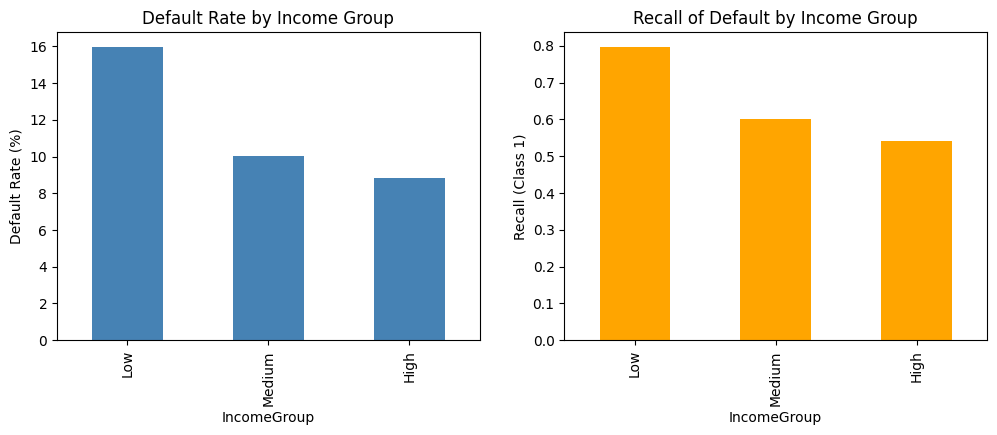

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
income_default_rates.plot(kind='bar', color='steelblue')
plt.title("Default Rate by Income Group")
plt.ylabel("Default Rate (%)")

plt.subplot(1,2,2)
income_recalls.plot(kind='bar', color='orange')
plt.title("Recall of Default by Income Group")
plt.ylabel("Recall (Class 1)")

plt.show()

### 4.7 Fairness by Income Group

The chart on the left shows that lower-income borrowers have a significantly higher default rate.
The chart on the right shows that the class-weighted model achieves the highest recall (correct
identification of default cases) for this same group.

This indicates that:

- Low-income borrowers default more frequently in the data.
- The model correctly identifies a greater proportion of risky loans in the low-income group
  compared to medium- and high-income borrowers.
- Despite higher performance for the low-income group, the difference in recall across groups
  suggests that model performance varies with income level.

Although the model improves prediction for high-risk groups, these variations imply that additional
calibration may be beneficial to ensure consistent decision-making across borrower income segments.

In [76]:
purpose_default_rates = fair_df.groupby('LoanPurpose').apply(default_rate).sort_values(ascending=False)
purpose_recalls = fair_df.groupby('LoanPurpose').apply(recall_default).sort_values(ascending=False)
purpose_default_rates, purpose_recalls

/var/folders/jj/l72sd2c50fsc18zws0_3f4ph0000gn/T/ipykernel_75697/2235595618.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purpose_default_rates = fair_df.groupby('LoanPurpose').apply(default_rate).sort_values(ascending=False)
/var/folders/jj/l72sd2c50fsc18zws0_3f4ph0000gn/T/ipykernel_75697/2235595618.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purpose_recalls = fair_df.groupby('LoanPurpose').apply(recal

(LoanPurpose
 Business     12.470711
 Other        12.029098
 Auto         11.698063
 Education    11.554152
 Home         10.319410
 dtype: float64,
 LoanPurpose
 Business     0.706681
 Education    0.699317
 Auto         0.682432
 Other        0.676026
 Home         0.605263
 dtype: float64)

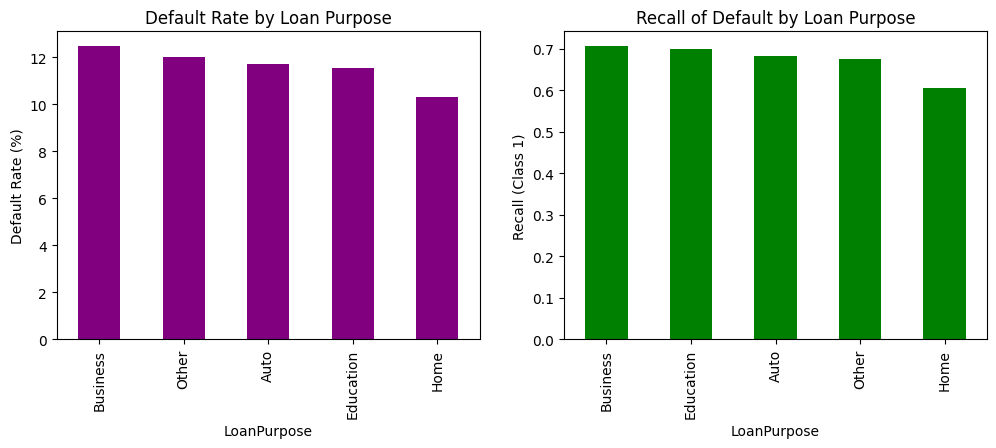

In [77]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
purpose_default_rates.plot(kind='bar', color='purple')
plt.title("Default Rate by Loan Purpose")
plt.ylabel("Default Rate (%)")

plt.subplot(1,2,2)
purpose_recalls.plot(kind='bar', color='green')
plt.title("Recall of Default by Loan Purpose")
plt.ylabel("Recall (Class 1)")

plt.show()

### Fairness by Loan Purpose

The default rate varies across loan purposes, with business and education loans showing slightly
higher default frequency. The model achieves relatively similar recall across categories, with
business and education loans receiving slightly better detection compared to auto and home loans.

Key observations:

- Business and education loans have the highest default incidence in the dataset.
- The class-weighted model performs reasonably consistently across loan purposes, with small
  differences in recall between categories.
- The model struggles slightly more with home loans, where fewer risky loans are detected.

Overall, the model shows more variability across income levels than across loan purposes. Further
feature engineering for loan purpose (for example, loan amount relative to income) may help capture
additional risk factors in future iterations.


### Limitations and Future Work

This project focused on comparing a baseline model and a class-weighted deep learning model using
embedding representations for categorical variables. Although the class-weighted model improved
default detection, several areas remain for future improvement:

- The dataset does not include protected demographic attributes (such as age category or ethnicity),
  which limits deeper fairness analysis.
- The model applies a global prediction threshold (0.50). Calibrating thresholds per group or using
  cost-sensitive thresholds may improve risk estimation consistency.
- Additional model architectures (e.g., deeper networks or attention mechanisms) and feature
  engineering (e.g., loan-to-income ratios by loan purpose) could further improve recall and group
  equity.

These extensions could help evaluate bias more comprehensively and improve predictive stability
across borrower segments.